In [1]:
import sys
import os
import lovely_tensors as lt

from lovely_numpy import lo

lt.monkey_patch()

sys.path.append("../")
if os.getcwd().split("/")[-1] == "notebooks":
    os.chdir("../")

In [ ]:
from ffss.data import CocoLVISCrop

import torch
import torch.nn.functional as F
import numpy as np
from transformers import ViTImageProcessor, ViTForImageClassification
from captum.attr import DeepLift, GuidedGradCam, IntegratedGradients, NoiseTunnel
from captum.attr import visualization as viz

/home/pasquale/miniconda3/envs/ffss/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class VitWrapper(ViTForImageClassification):
    def forward(self, *args, **kwargs):
        outputs = super().forward(*args, **kwargs)
        return outputs.logits

In [4]:
def attribute_image_features(net, algorithm, input, target,  **kwargs):
    net.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=target,
                                              **kwargs
                                                )
    
    return tensor_attributions
        

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit_processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
processor = lambda x: vit_processor(images=x, return_tensors="pt")['pixel_values']
vit = VitWrapper.from_pretrained('google/vit-base-patch16-224').to(device)

In [6]:
# coco = CocoLVISDataset(
#     instances_path="../datasets/coco/annotations/instances_train2017.json",
#     img_dir="../datasets/coco/train2017",
#     preprocess=processor
# )
coco_crop = CocoLVISCrop(
    instances_path="../datasets/coco/annotations/instances_train2017.json",
    img_dir="../datasets/coco/train2017",
    preprocess=processor
)

Loading dataset annotations from ../datasets/coco/annotations/instances_train2017.json...


In [7]:
i = 2
batch = coco_crop[i]
image = batch['image'].to(device)

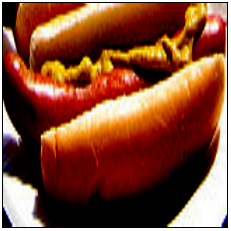

In [8]:
image.rgb

In [9]:
out = vit(image)
probabilities = F.softmax(out, dim=-1)

In [10]:
# Associate a probabiliries with a label and sort them
sorted_probs = sorted([(vit.config.id2label[i], prob, i) for i, prob in enumerate(probabilities[0])], key=lambda x: x[1], reverse=True)
sorted_probs

[('hotdog, hot dog, red hot', tensor grad UnbindBackward0 cuda:0 0.998, 934),
 ('pretzel', tensor grad UnbindBackward0 cuda:0 0.000, 932),
 ('cheeseburger', tensor grad UnbindBackward0 cuda:0 0.000, 933),
 ('French loaf', tensor grad UnbindBackward0 cuda:0 0.000, 930),
 ('ear, spike, capitulum', tensor grad UnbindBackward0 cuda:0 7.139e-05, 998),
 ('bagel, beigel', tensor grad UnbindBackward0 cuda:0 4.731e-05, 931),
 ('packet', tensor grad UnbindBackward0 cuda:0 3.830e-05, 692),
 ('plate', tensor grad UnbindBackward0 cuda:0 3.431e-05, 923),
 ('restaurant, eating house, eating place, eatery',
  tensor grad UnbindBackward0 cuda:0 2.757e-05,
  762),
 ('American lobster, Northern lobster, Maine lobster, Homarus americanus',
  tensor grad UnbindBackward0 cuda:0 2.505e-05,
  122),
 ('mashed potato', tensor grad UnbindBackward0 cuda:0 1.827e-05, 935),
 ('bakery, bakeshop, bakehouse',
  tensor grad UnbindBackward0 cuda:0 1.529e-05,
  415),
 ('meat loaf, meatloaf', tensor grad UnbindBackward0 c

In [11]:
batch

{'image': tensor[1, 3, 224, 224] n=150528 (0.6Mb) x∈[-0.976, 1.000] μ=0.147 σ=0.548,
 'image_id': 200365,
 'target': 58}

In [12]:
dl = DeepLift(vit)
ig = IntegratedGradients(vit)
nt = NoiseTunnel(ig)

In [13]:
target = sorted_probs[0][2]
attr_dl = attribute_image_features(vit, dl, image, target=target, baselines=image * 0)
attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

attr_ig_nt = attribute_image_features(vit, nt, image, target=target, baselines=image * 0, nt_type='smoothgrad_sq',
                                      nt_samples=100, stdevs=0.2, internal_batch_size=5)
attr_ig_nt = np.transpose(attr_ig_nt.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

OutOfMemoryError: CUDA out of memory. Tried to allocate 58.00 MiB. GPU 0 has a total capacity of 23.64 GiB of which 50.94 MiB is free. Process 2774930 has 4.79 GiB memory in use. Process 3629534 has 4.89 GiB memory in use. Process 941035 has 3.24 GiB memory in use. Including non-PyTorch memory, this process has 10.57 GiB memory in use. Of the allocated memory 10.01 GiB is allocated by PyTorch, and 98.99 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

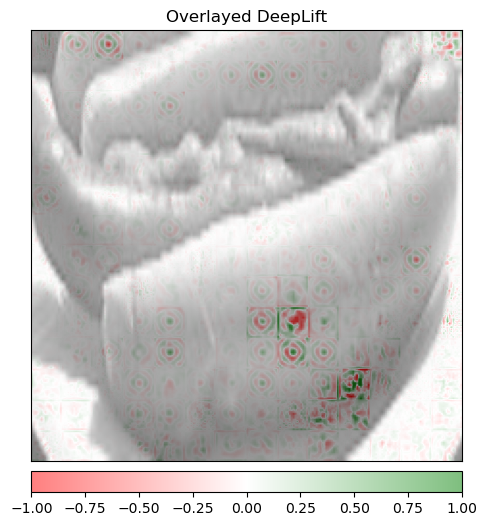

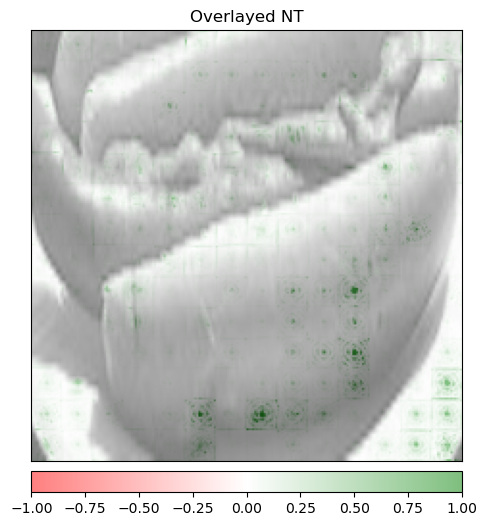

In [ ]:
original_image = np.transpose((batch['image'][0].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))
_ = viz.visualize_image_attr(attr_dl, original_image, method="blended_heat_map",sign="all",show_colorbar=True, 
                          title="Overlayed DeepLift")
_ = viz.visualize_image_attr(attr_ig_nt, original_image, method="blended_heat_map",sign="all",show_colorbar=True, 
                          title="Overlayed NT")

In [56]:
import matplotlib.pyplot as plt

from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [57]:
deit = torch.hub.load('facebookresearch/deit:main',
                           'deit_tiny_patch16_224', pretrained=True).to(device)

Using cache found in /home/pasquale/.cache/torch/hub/facebookresearch_deit_main


In [58]:
from torchvision.models import resnet50

resnet = resnet50(pretrained=True).cuda()
model_outputs = resnet(image)

In [59]:
def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1 :  , :].reshape(tensor.size(0),
        height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

In [60]:
def gradcam(model, image, target_layers, id2label, reshape_transform):
    model_outputs = model(image)
    probabilities = F.softmax(model_outputs, dim=-1)
    sorted_probs = sorted([(id2label[i], prob, i) for i, prob in enumerate(probabilities[0])], key=lambda x: x[1], reverse=True)
    print(sorted_probs)
    target = sorted_probs[0][2]
    
    targets = [ClassifierOutputTarget(target)]

    with GradCAM(model, target_layers=target_layers, reshape_transform=reshape_transform) as cam:
        # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
        grayscale_cam = cam(input_tensor=image, targets=targets)
        # In this example grayscale_cam has only one image in the batch:
        grayscale_cam = grayscale_cam[0, :]
        visualization = show_cam_on_image(original_image, grayscale_cam, use_rgb=True)
        # You can also get the model outputs without having to redo inference
        model_outputs = cam.outputs
    return lo(visualization).rgb.fig

[('hook, claw', tensor grad UnbindBackward0 cuda:0 0.006, 600), ('bucket, pail', tensor grad UnbindBackward0 cuda:0 0.006, 463), ('tennis ball', tensor grad UnbindBackward0 cuda:0 0.006, 852), ("plunger, plumber's helper", tensor grad UnbindBackward0 cuda:0 0.005, 731), ('ladle', tensor grad UnbindBackward0 cuda:0 0.005, 618), ('paper towel', tensor grad UnbindBackward0 cuda:0 0.004, 700), ('water jug', tensor grad UnbindBackward0 cuda:0 0.004, 899), ('pole', tensor grad UnbindBackward0 cuda:0 0.004, 733), ('water bottle', tensor grad UnbindBackward0 cuda:0 0.004, 898), ('wooden spoon', tensor grad UnbindBackward0 cuda:0 0.004, 910), ('paintbrush', tensor grad UnbindBackward0 cuda:0 0.004, 696), ('chain', tensor grad UnbindBackward0 cuda:0 0.004, 488), ('spatula', tensor grad UnbindBackward0 cuda:0 0.004, 813), ('whistle', tensor grad UnbindBackward0 cuda:0 0.003, 902), ('caldron, cauldron', tensor grad UnbindBackward0 cuda:0 0.003, 469), ('hammer', tensor grad UnbindBackward0 cuda:0 0

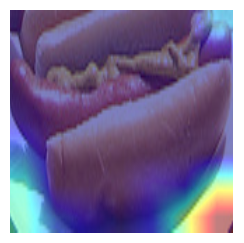

In [61]:
gradcam(resnet, image, target_layers=[resnet.layer4[-1]], id2label=vit.config.id2label, reshape_transform=None)

[('hotdog, hot dog, red hot', tensor grad UnbindBackward0 cuda:0 0.402, 934), ('cheeseburger', tensor grad UnbindBackward0 cuda:0 0.052, 933), ('pretzel', tensor grad UnbindBackward0 cuda:0 0.015, 932), ('French loaf', tensor grad UnbindBackward0 cuda:0 0.011, 930), ('bagel, beigel', tensor grad UnbindBackward0 cuda:0 0.011, 931), ('airship, dirigible', tensor grad UnbindBackward0 cuda:0 0.008, 405), ("jack-o'-lantern", tensor grad UnbindBackward0 cuda:0 0.003, 607), ('kite', tensor grad UnbindBackward0 cuda:0 0.003, 21), ('wing', tensor grad UnbindBackward0 cuda:0 0.003, 908), ('orange', tensor grad UnbindBackward0 cuda:0 0.003, 950), ('potpie', tensor grad UnbindBackward0 cuda:0 0.003, 964), ('shower curtain', tensor grad UnbindBackward0 cuda:0 0.003, 794), ('tick', tensor grad UnbindBackward0 cuda:0 0.003, 78), ('ballpoint, ballpoint pen, ballpen, Biro', tensor grad UnbindBackward0 cuda:0 0.003, 418), ('bald eagle, American eagle, Haliaeetus leucocephalus', tensor grad UnbindBackwar

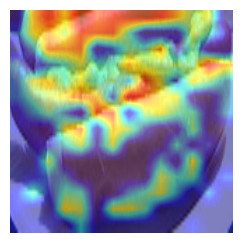

In [62]:
gradcam(deit, image, target_layers=[deit.blocks[-1].norm1], id2label=vit.config.id2label, reshape_transform=reshape_transform)

[('hotdog, hot dog, red hot', tensor grad UnbindBackward0 cuda:0 0.998, 934), ('pretzel', tensor grad UnbindBackward0 cuda:0 0.000, 932), ('cheeseburger', tensor grad UnbindBackward0 cuda:0 0.000, 933), ('French loaf', tensor grad UnbindBackward0 cuda:0 0.000, 930), ('ear, spike, capitulum', tensor grad UnbindBackward0 cuda:0 7.139e-05, 998), ('bagel, beigel', tensor grad UnbindBackward0 cuda:0 4.731e-05, 931), ('packet', tensor grad UnbindBackward0 cuda:0 3.830e-05, 692), ('plate', tensor grad UnbindBackward0 cuda:0 3.431e-05, 923), ('restaurant, eating house, eating place, eatery', tensor grad UnbindBackward0 cuda:0 2.757e-05, 762), ('American lobster, Northern lobster, Maine lobster, Homarus americanus', tensor grad UnbindBackward0 cuda:0 2.505e-05, 122), ('mashed potato', tensor grad UnbindBackward0 cuda:0 1.827e-05, 935), ('bakery, bakeshop, bakehouse', tensor grad UnbindBackward0 cuda:0 1.529e-05, 415), ('meat loaf, meatloaf', tensor grad UnbindBackward0 cuda:0 1.490e-05, 962), (

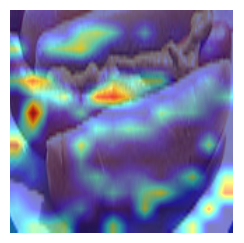

In [64]:
target_layers = [vit.vit.encoder.layer[-2].layernorm_after]
gradcam(vit, image, target_layers=target_layers, id2label=vit.config.id2label, reshape_transform=reshape_transform)